## ResNet 50 + ArcFace

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import optimizers, regularizers

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import math

In [2]:
trainImagePath = '../dataSet/splitImages/train'
validationImagePath = '../dataSet/splitImages/val'
testImagePath = '../dataSet/splitImages/test'
checkpointPath = '../test/checkpoints/epoch_{epoch:04d}.h5'
logsPath = '../test/logs/fit/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
bestCheckpointPath = '../test/model/epoch_{epoch:04d}.h5'
savedModelPath = '../test/model/resnet50.h5'

batchSize = 16
imageWidth = 300
imageHeight = 300
imageChannel = 3
input_shape = (imageWidth, imageHeight, imageChannel)
n_classes = 50
dropout_rate = 0.0


### 이미지 데이터 생성

ImageDataGenerator (train, validation)

In [3]:
trainDataGen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.2,
                                  zoom_range=-0.3,
                                  horizontal_flip=False,
                                  vertical_flip=False,
                                  brightness_range=[0.7, 1.3],
                                  fill_mode='nearest'
                                  )

train set

In [4]:
trainGenSet = trainDataGen.flow_from_directory(
    trainImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical',
    shuffle=True
)

Found 7108 images belonging to 50 classes.


In [5]:
x_train,y_train = trainGenSet.next()

(300, 300, 3)


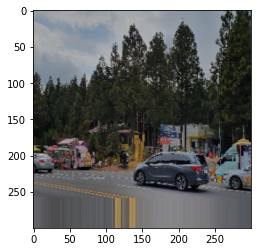

In [6]:
print(x_train[0].shape)
plt.imshow(x_train[13])
plt.show()

validation set

In [7]:
validationGenSet = trainDataGen.flow_from_directory(
    validationImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical'
)

Found 870 images belonging to 50 classes.


ImageDataGenerator (train, validation)

In [8]:
testDataGen = ImageDataGenerator(rescale=1./255)

test set

In [9]:
testGenSet = testDataGen.flow_from_directory(
    testImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical'
)

Found 929 images belonging to 50 classes.


In [10]:
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [11]:
backbone = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights=('imagenet'))

pooling = tf.keras.layers.GlobalAveragePooling2D(name='head/pooling')
dropout = tf.keras.layers.Dropout(dropout_rate, name='head/dropout')
dense = tf.keras.layers.Dense(256, name='head/dense')

margin = ArcMarginProduct(
            n_classes = n_classes, 
            s = 30, 
            m = 0.5, 
            name='head/arc_margin', 
            dtype='float32'
            )

inp = tf.keras.layers.Input(shape = input_shape, name = 'inp1')
label = tf.keras.layers.Input((), name = 'inp2')

x = backbone(inp)
x = pooling(x)
x = dropout(x)
x = dense(x)
x = margin([x, label])
output = Dense(n_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])

model.summary()

2022-06-19 16:22:15.008798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-19 16:22:15.680752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13690 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 10, 10, 2048  23587712    ['inp1[0][0]']                   
                                )                                                                 
                                                                                                  
 head/pooling (GlobalAveragePoo  (None, 2048)        0           ['resnet50[0][0]']               
 ling2D)                                                                                      

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])

In [13]:
checkpoint = ModelCheckpoint(
                        checkpointPath, monitor='val_loss', verbose=0, save_best_only=False,
                        save_weights_only=False, mode='auto', save_freq='epoch'
                    )


In [14]:
earlyStopping = [
                    EarlyStopping(monitor='val_loss',verbose=0, patience=10, ),
                    ModelCheckpoint( bestCheckpointPath, monitor='val_loss', save_best_only=True )
                ]

In [15]:
tensorboard = tf.keras.callbacks.TensorBoard(logsPath)

In [16]:
class Dataset(Sequence) :
    
    def __init__(self,generator) :
        self.generator = generator
    def __len__(self) :
        return len(self.generator)
    def __getitem__(self,idx) :
        x = self.generator[idx] [0]
        y = np.argmax(self.generator[idx] [1],axis=1)
        return (x,y),y

In [17]:
trainDataSet = Dataset(trainGenSet)
valDataSet = Dataset(validationGenSet)

In [18]:
epochs = 1
history = model.fit(
    trainDataSet,
    epochs=epochs,
    validation_data=valDataSet,
    callbacks=[checkpoint,earlyStopping, tensorboard],
    verbose=1
)

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 50) are incompatible


In [15]:
scores = model_final.evaluate(testGenSet)
print(scores)

30/30 [==============================] - 75s 2s/step - loss: 2.1905 - accuracy: 0.4952
[2.1905038356781006, 0.49515607953071594]


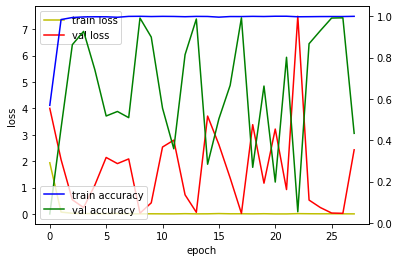

In [16]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

In [17]:
model.save(savedModelPath)

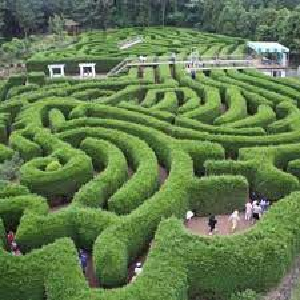

In [18]:
testImage = load_img("../testImage.jpg", target_size = (imageHeight, imageWidth))
testImage

In [19]:
testImage = img_to_array(testImage)
testImage = testImage/255.0

print(testImage)

[[[0.2627451  0.32941177 0.30588236]
  [0.22745098 0.29411766 0.27058825]
  [0.22745098 0.29411766 0.27058825]
  ...
  [0.36862746 0.4392157  0.45490196]
  [0.36862746 0.4392157  0.45490196]
  [0.36862746 0.44705883 0.4392157 ]]

 [[0.29411766 0.36078432 0.3372549 ]
  [0.20392157 0.27058825 0.24705882]
  [0.20392157 0.27058825 0.24705882]
  ...
  [0.32156864 0.39215687 0.4       ]
  [0.32156864 0.39215687 0.4       ]
  [0.29803923 0.3764706  0.36862746]]

 [[0.29411766 0.36078432 0.3372549 ]
  [0.20392157 0.27058825 0.24705882]
  [0.20392157 0.27058825 0.24705882]
  ...
  [0.32156864 0.39215687 0.4       ]
  [0.32156864 0.39215687 0.4       ]
  [0.29803923 0.3764706  0.36862746]]

 ...

 [[0.14509805 0.24313726 0.1254902 ]
  [0.14509805 0.24313726 0.1254902 ]
  [0.14509805 0.24313726 0.1254902 ]
  ...
  [0.50980395 0.5568628  0.4       ]
  [0.50980395 0.5568628  0.4       ]
  [0.5058824  0.54509807 0.40784314]]

 [[0.14509805 0.24313726 0.1254902 ]
  [0.14509805 0.24313726 0.1254902 ]


In [22]:
confidence = model_final.predict(testImage.reshape((1, imageHeight, imageWidth, imageChannel)))

1/1 [==============================] - 2s 2s/step


In [23]:
for i in range(confidence.shape[1]):
    print(f"{i} 일 확률 = {round(confidence[0][i], 3)}")

print(f"정답은 : {np.argmax(confidence, axis=1)}")

0 일 확률 = 0.0
1 일 확률 = 0.0010000000474974513
2 일 확률 = 0.0
3 일 확률 = 0.012000000104308128
4 일 확률 = 0.9789999723434448
5 일 확률 = 0.0
6 일 확률 = 0.0
7 일 확률 = 0.0
8 일 확률 = 0.0
9 일 확률 = 0.0
10 일 확률 = 0.0
11 일 확률 = 0.0020000000949949026
12 일 확률 = 0.0
13 일 확률 = 0.0
14 일 확률 = 0.0010000000474974513
15 일 확률 = 0.0
16 일 확률 = 0.0
17 일 확률 = 0.0
18 일 확률 = 0.0
19 일 확률 = 0.0
20 일 확률 = 0.0
21 일 확률 = 0.0010000000474974513
22 일 확률 = 0.0
23 일 확률 = 0.0
24 일 확률 = 0.0
25 일 확률 = 0.0
26 일 확률 = 0.0
27 일 확률 = 0.0
28 일 확률 = 0.0
29 일 확률 = 0.0
30 일 확률 = 0.0
31 일 확률 = 0.0
32 일 확률 = 0.0
33 일 확률 = 0.0
34 일 확률 = 0.0
35 일 확률 = 0.0
36 일 확률 = 0.0
37 일 확률 = 0.0
38 일 확률 = 0.0
39 일 확률 = 0.0
40 일 확률 = 0.0
41 일 확률 = 0.0
42 일 확률 = 0.0
43 일 확률 = 0.0
44 일 확률 = 0.0
45 일 확률 = 0.0
46 일 확률 = 0.0
47 일 확률 = 0.0
48 일 확률 = 0.0
49 일 확률 = 0.0
정답은 : [4]


In [27]:
dfTrain = pd.read_csv('../categoryList.csv', encoding='cp949')
dfTrain.head()

,categoryNumber,categoryName
0,0,감귤박물관
1,1,검멀레동굴
2,2,관덕정
3,3,구엄리돌염전
4,4,김녕미로공원


In [35]:
dfTrain['categoryName'][np.argmax(confidence, axis=1)]

4    김녕미로공원
Name: categoryName, dtype: object